In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
def get_class_from_filename(filename): 
    p = filename.split('/')[-1].split('_')
    return p[0] + '|' + p[1]


def get_class_id_from_filename(filename):
    p = filename.split('/')[-1].split('_')
    if p[1] == "left":
        class_id = (int(p[0]) - 1) * 2
    else:
        class_id = 2 * int(p[0]) - 1
    return class_id


def get_all_filenames(root):
    filenames = []
    for file in os.listdir(root):
        if file.endswith('.bmp'):
            filenames.append(os.path.join(root, file))
    return filenames

In [3]:
root = "/content/gdrive/MyDrive/Курсова/code/iris_files"
all_files = get_all_filenames(root)
classnames = list(map(get_class_from_filename, all_files))
class_ids = list(map(get_class_id_from_filename, all_files))

data_dct = {"filename": all_files, "classname": classnames, "class_id": class_ids}
df = pd.DataFrame(data_dct)
df.head(10)

,filename,classname,class_id
0,/content/gdrive/MyDrive/Курсова/code/iris_file...,1|left,0
1,/content/gdrive/MyDrive/Курсова/code/iris_file...,1|left,0
2,/content/gdrive/MyDrive/Курсова/code/iris_file...,1|left,0
3,/content/gdrive/MyDrive/Курсова/code/iris_file...,1|left,0
4,/content/gdrive/MyDrive/Курсова/code/iris_file...,1|left,0
5,/content/gdrive/MyDrive/Курсова/code/iris_file...,1|right,1
6,/content/gdrive/MyDrive/Курсова/code/iris_file...,1|right,1
7,/content/gdrive/MyDrive/Курсова/code/iris_file...,1|right,1
8,/content/gdrive/MyDrive/Курсова/code/iris_file...,1|right,1
9,/content/gdrive/MyDrive/Курсова/code/iris_file...,1|right,1


In [4]:
import tensorflow as tf
import tensorflow_hub as hub

u, c = np.unique(df.class_id, return_counts = True)
y = u[c < 4]
for cl in y:
    ind = df.index[df.class_id == cl]
    df.drop(ind, axis=0, inplace=True)
df.shape

(380, 3)

In [5]:
csv_train = []
csv_val = []

for class_id in np.unique(df.class_id):
    csv_sliced = df[df.class_id == class_id].sample(frac=1)
    csv_train.append(csv_sliced.iloc[:-2])
    csv_val.append(csv_sliced.iloc[-2:])
    
csv_train = pd.concat(csv_train, axis=0)
csv_val = pd.concat(csv_val, axis=0)

csv_train.head(10)

,filename,classname,class_id
3,/content/gdrive/MyDrive/Курсова/code/iris_file...,1|left,0
0,/content/gdrive/MyDrive/Курсова/code/iris_file...,1|left,0
2,/content/gdrive/MyDrive/Курсова/code/iris_file...,1|left,0
8,/content/gdrive/MyDrive/Курсова/code/iris_file...,1|right,1
7,/content/gdrive/MyDrive/Курсова/code/iris_file...,1|right,1
9,/content/gdrive/MyDrive/Курсова/code/iris_file...,1|right,1
12,/content/gdrive/MyDrive/Курсова/code/iris_file...,2|left,2
10,/content/gdrive/MyDrive/Курсова/code/iris_file...,2|left,2
11,/content/gdrive/MyDrive/Курсова/code/iris_file...,2|left,2
17,/content/gdrive/MyDrive/Курсова/code/iris_file...,2|right,3


In [6]:
def prep_image(file):
    img_data = tf.io.read_file(file)
    img = tf.io.decode_bmp(img_data, channels=3)
    img = tf.image.rgb_to_grayscale(img)
    img /= 255
    return img


def make_dataset(_csv):
    files = _csv.filename
    ds_files = tf.data.Dataset.from_tensor_slices(files)
    ds_label = tf.data.Dataset.from_tensor_slices(_csv.class_id.to_numpy())
    ds_files = ds_files.map(prep_image)
    ds = tf.data.Dataset.zip((ds_files, ds_label))
    return ds


ds_train = make_dataset(csv_train).shuffle(512).batch(64)
ds_val = make_dataset(csv_val).batch(64)

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,360,1)),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings

])

In [8]:
# !pip install -q -U tensorflow-addons
import tensorflow_addons as tfa

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss())

In [9]:
# Train the network
history = model.fit(
    ds_train,
    epochs=30)

Epoch 1/30
4/4 [==============================] - 9s 196ms/step - loss: 0.9980
Epoch 2/30
4/4 [==============================] - 1s 67ms/step - loss: 0.9966
Epoch 3/30
4/4 [==============================] - 1s 74ms/step - loss: 0.9948
Epoch 4/30
4/4 [==============================] - 1s 69ms/step - loss: 0.9923
Epoch 5/30
4/4 [==============================] - 1s 65ms/step - loss: 0.9935
Epoch 6/30
4/4 [==============================] - 1s 67ms/step - loss: 0.9887
Epoch 7/30
4/4 [==============================] - 1s 75ms/step - loss: 0.9811
Epoch 8/30
4/4 [==============================] - 1s 71ms/step - loss: 0.9752
Epoch 9/30
4/4 [==============================] - 1s 68ms/step - loss: 0.9501
Epoch 10/30
4/4 [==============================] - 1s 76ms/step - loss: 0.9345
Epoch 11/30
4/4 [==============================] - 1s 70ms/step - loss: 0.9246
Epoch 12/30
4/4 [==============================] - 1s 77ms/step - loss: 0.8882
Epoch 13/30
4/4 [==============================] - 1s 78ms/s

In [17]:
# Evaluate the network
def extract_descriptors(_ds):
    descriptors = []
    labels = []
    
    for batch_img, batch_label in _ds:
        batch_descriptors = model.predict(batch_img)
        batch_label = batch_label.numpy()
        descriptors.append(batch_descriptors)
        labels.append(batch_label)
        
    descriptors = np.concatenate(descriptors, axis=0)
    labels = np.concatenate(labels, axis=0)
        
    return descriptors, labels


train_descriptors, train_labels = extract_descriptors(ds_train)
val_descriptors, val_labels = extract_descriptors(ds_val)

Knn score: 0.7468354430379747
Knn score train: 0.9279279279279279


  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

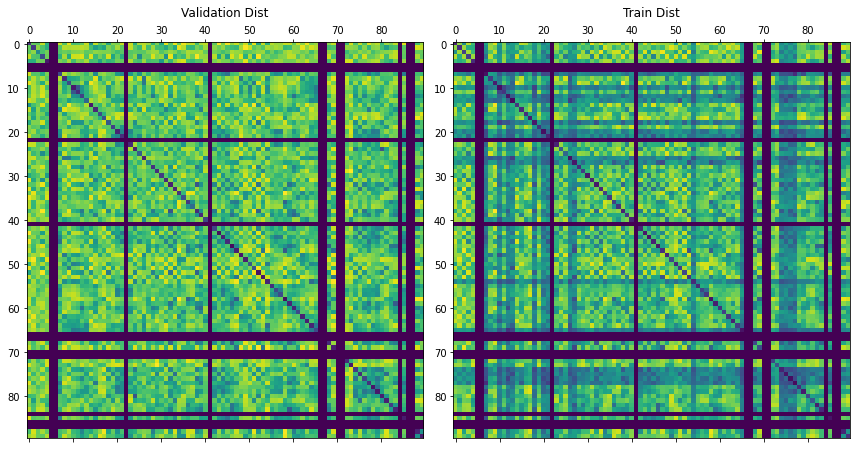

In [19]:
from tqdm.notebook import tqdm
from sklearn.neighbors import KNeighborsClassifier

def desc_cv_dist(descriptors, labels):
    classes = np.max(labels) + 1
    mymap = np.zeros([classes, classes])

    _d = descriptors.copy()
    _l = labels.copy()

    for i in  tqdm(range(len(labels))):
        distances = np.sqrt(np.mean((descriptors-_d)**2, axis=-1))

        for i in range(len(labels)):
            dist = distances[i]
            mymap[_l[i], labels[i]] += dist
            mymap[labels[i], _l[i]] += dist

        _d = np.roll(_d, shift=1, axis=0)
        _l = np.roll(_l, shift=1, axis=0)
    return mymap


knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_descriptors, train_labels)
knn_score = knn.score(val_descriptors, val_labels)
knn_score_train = knn.score(train_descriptors, train_labels)
knn_predict = knn.predict(val_descriptors)
knn_predict_train = knn.predict(train_descriptors)
print(f'Knn score: {knn_score}')
print(f'Knn score train: {knn_score_train}')


# cm = confusion_matrix(val_labels, knn_predict)
# cm_train = confusion_matrix(train_labels, knn_predict_train)
# fig, ax = plt.subplots(ncols=2, figsize=(12, 8))
# ax[0].matshow(cm)
# ax[0].set_title('Validation CM')
# ax[1].matshow(cm_train)
# ax[1].set_title('Train CM')
# fig.tight_layout()
# plt.show()

map_dist_train = desc_cv_dist(train_descriptors, train_labels)
map_dist_val = desc_cv_dist(val_descriptors, val_labels)

fig, ax = plt.subplots(ncols=2, figsize=(12, 8))
ax[0].matshow(map_dist_val)
ax[0].set_title('Validation Dist')
ax[1].matshow(map_dist_train)
ax[1].set_title('Train Dist')
fig.tight_layout()
plt.show()

In [20]:
from scipy.spatial import distance_matrix
distance_matrix_train = distance_matrix(train_descriptors, train_descriptors, p=2)
distance_matrix_train

array([[0.        , 0.52619997, 1.07866662, ..., 1.31959386, 1.17301722,
        1.06829266],
       [0.52619997, 0.        , 1.22325499, ..., 1.47205034, 1.39419013,
        1.10848653],
       [1.07866662, 1.22325499, 0.        , ..., 1.06362791, 1.23512094,
        0.8318089 ],
       ...,
       [1.31959386, 1.47205034, 1.06362791, ..., 0.        , 1.43356092,
        1.41087547],
       [1.17301722, 1.39419013, 1.23512094, ..., 1.43356092, 0.        ,
        1.25175045],
       [1.06829266, 1.10848653, 0.8318089 , ..., 1.41087547, 1.25175045,
        0.        ]])

Text(0.5, 1.0, 'Different class distances')

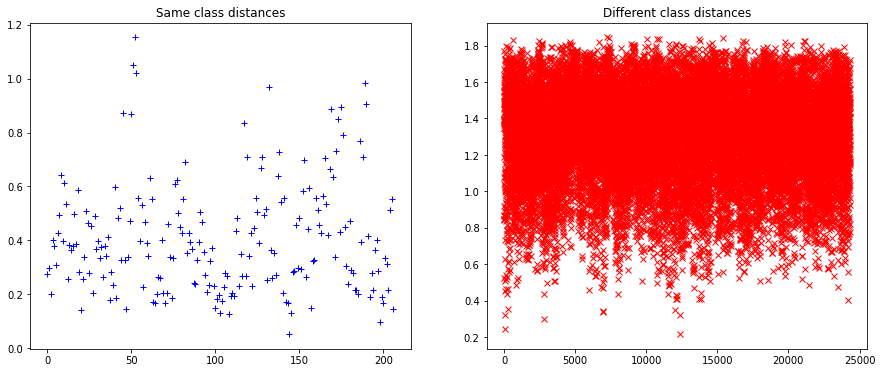

In [21]:
from itertools import combinations

same_class_dists = []
diff_class_dists = []
same_class_indices = []

for label in np.unique(train_labels):
    ind = np.where(train_labels == label)[0]
    for i, j in list(combinations(ind, 2)):
        same_class_dists.append(distance_matrix_train[i][j])
        same_class_indices.append((i, j))

for i in range(len(train_labels)):
    for j in range(len(train_labels)):
        if j > i:
            if (i, j) not in same_class_indices:
               diff_class_dists.append(distance_matrix_train[i][j]) 

fig, ax = plt.subplots(ncols=2, figsize=(15, 6))
ax[0].plot(same_class_dists, 'b+')
ax[0].set_title('Same class distances')
ax[1].plot(diff_class_dists, 'rx')
ax[1].set_title('Different class distances')

In [47]:
threshold = 0.7

distance_matrix_val = distance_matrix(val_descriptors, val_descriptors, p=2)
result = np.where(distance_matrix_val < threshold, 1, 0)
result

array([[1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 1, 1]])

In [48]:
from itertools import combinations_with_replacement

gr_truth = np.zeros((len(val_labels), len(val_labels)))

for label in np.unique(val_labels):
    ind = np.where(val_labels == label)[0]
    for i, j in list(combinations_with_replacement(ind, 2)):
        gr_truth[i, j] = 1
        gr_truth[j, i] = 1
gr_truth

array([[1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 1., 1.]])

In [49]:
# model evaluation

acc = np.sum(result == gr_truth) / (gr_truth.shape[0] * gr_truth.shape[1])
fp = np.sum((result == 1) & (gr_truth == 0)) / (gr_truth.shape[0] * gr_truth.shape[1])
fn = np.sum((result == 0) & (gr_truth == 1)) / (gr_truth.shape[0] * gr_truth.shape[1])
print(f"Accuracy score: {acc}")
print(f"FP rate: {fp}")
print(f"FN rate: {fn}")

Accuracy score: 0.9789296587085403
FP rate: 0.01946803396891524
FN rate: 0.001602307322544464
